# Generate New Images
This notebook can be used to generate new images using supplied weights in the model folder

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sys
sys.path.append("../src")

In [2]:
import numpy as np
from PIL import Image
from skimage import io
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import torch

from dataset.birds_dataset import BirdsDataset
from models.discriminator import Discriminator
from models.generator import GeneratorNetwork
from models.conditional_augmentation import ConditioningAugmentation
from models.text_encoder import TextEncoder
from models.image_encoder import ImageEncoder

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

In [5]:
!pwd

/home/user_2/AttnGAN/Matan/AttnGAN/notebooks


In [24]:
##### BAD:
# weights = torch.load("../models/attngan/working_mid_models/epoch_131_second_run.pt")
# weights = torch.load("../models/attngan/best_attngan/50_epoch_first_run.pt")

### NEUTRAL
# weights = torch.load("../models/attngan/best_attngan/100_epochs_second_run.pt")
# weights = torch.load("../models/attngan/best_attngan/330_epochs_third_run.pt")

##### GOOD:
# weights = torch.load("../models/attngan/working_mid_models/epoch_160_second_run.pt")

#### TO TRY:
weights = torch.load("../models/attngan/best_attngan/330_epochs_third_run.pt")



In [25]:
bd = BirdsDataset('/home/user_2/AttnGAN/datasets/cub200-2011/preprocessing', base_image_size=64, number_images=3)
te = TextEncoder(bd.vocabulary.freqs.B())
te.load_state_dict(weights['models']['text_encoder'])
g = GeneratorNetwork()
_ = g.eval()
g.load_state_dict(weights['models']['generator'])
ca = ConditioningAugmentation()
ca.load_state_dict(weights['models']['conditional_augmentation'])
te = te.to(device)
g = g.to(device)
ca = ca.to(device)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [26]:
def generate_new_image(draw=True, sentences=None):
    """If draw is False, sentences must be a list of sentences to use """
    if draw:
        sample = bd.draw_random_sample()
        caption = sample.caption
        captions = sample.caption.unsqueeze(0).to(device)
        captions_length = sample.caption_length.unsqueeze(0)
    else:
        caption, caption_length = bd.choose_and_process_caption(sentences)
        captions = caption.unsqueeze(0).to(device)
        captions_length = caption_length.unsqueeze(0)
        
    encoded_words, (encoded_sentence, _) = te(captions, captions_length)
    words_mask = captions == bd.vocabulary.stoi['<eos>']
    words_mask = words_mask[:, :encoded_words.size(2)]
    conditioned_vec, mu, logvar = ca(encoded_sentence)
    z = torch.randn(conditioned_vec.shape[0], 100).to(device) # Noise vector
    gan_input = torch.cat([conditioned_vec, z], dim=1)  # the concatentated conditioning with the noise
    g_images, maps = g(gan_input, encoded_words, words_mask)
    images = []
    for i, g_image in enumerate(g_images):        
        g_image = g_image.squeeze(0).permute(1,2,0).contiguous().to('cpu').detach().numpy()
        g_image = ((g_image + 1.0) * 127.5).astype(np.uint8)
        images.append(Image.fromarray(g_image))

    l = [bd.idx2token(idx) for idx in caption if bd.idx2token(idx) != '<eos>']
    return " ".join(l), images

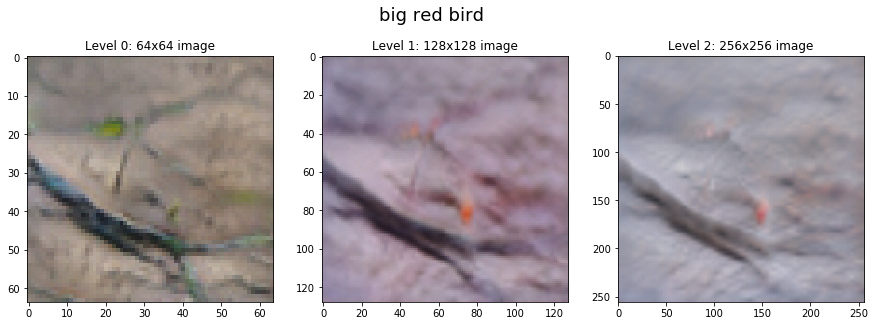

In [29]:
# Use my sentences
num_images = 1
for i in range(num_images):
    
    sentence = 'big red bird '
    caption, images = generate_new_image(draw=False, sentences=[sentence])
    _ = plt.figure(figsize=(15,5))
    _ = plt.suptitle("{}".format(caption), fontsize=18)
    _ = plt.subplot(1,3,1)
    _ = plt.imshow(np.array(images[0]))
    _ = plt.title("Level 0: 64x64 image")
    _ = plt.subplot(1,3,2)
    _ = plt.imshow(np.array(images[1]))
    _ = plt.title("Level 1: 128x128 image")
    _ = plt.subplot(1,3,3)
    _ = plt.imshow(np.array(images[2]))
    _ = plt.title("Level 2: 256x256 image")
    _ = plt.grid(False)
    
    plt.savefig("{}.png".format(sentence))

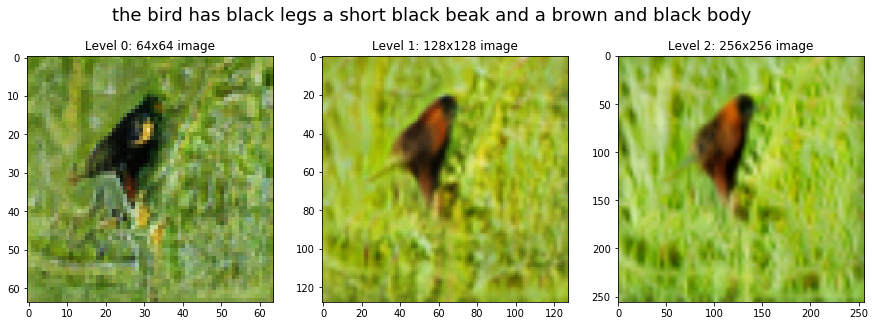

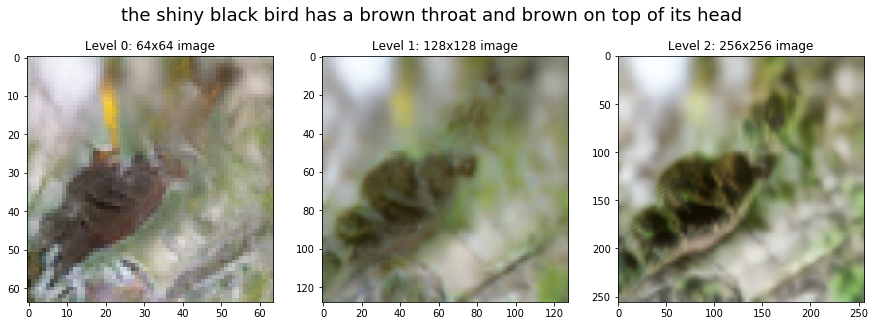

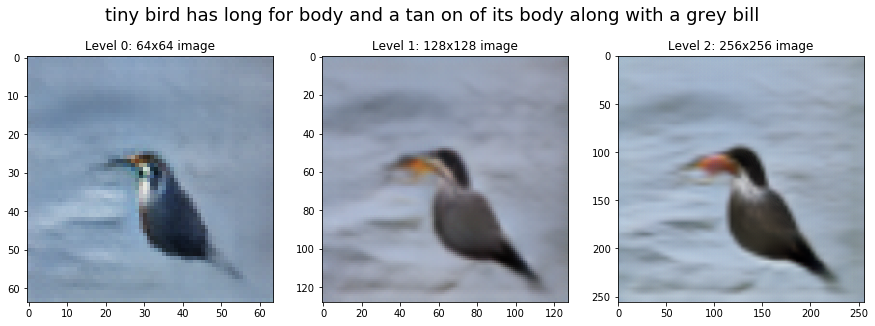

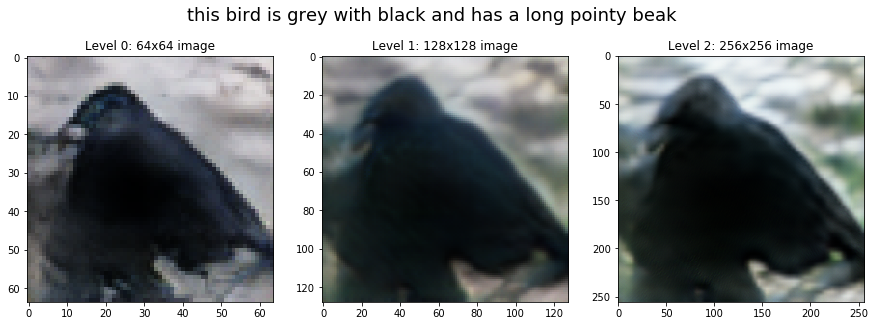

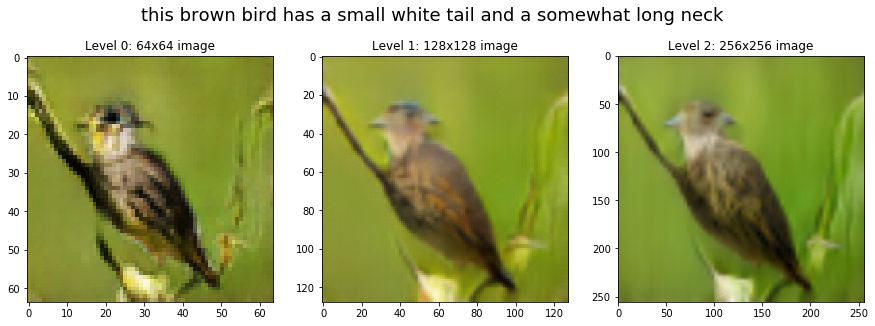

In [31]:
num_images = 5
for i in range(num_images):
    caption, images = generate_new_image()
    _ = plt.figure(figsize=(15,5))
    _ = plt.subplot(1,3,1)
    _ = plt.imshow(np.array(images[0]), )
    _ = plt.title("Level 0: 64x64 image")
    _ = plt.subplot(1,3,2)
    _ = plt.imshow(np.array(images[1]))
    _ = plt.title("Level 1: 128x128 image")
    _ = plt.subplot(1,3,3)
    _ = plt.imshow(np.array(images[2]))
    _ = plt.title("Level 2: 256x256 image")
    _ = plt.grid(False)
    _ = plt.suptitle("{}".format(caption), fontsize=18)
    plt.savefig("bla_{}.png".format(i))